In [8]:
import tensorflow as tf 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [11]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

In [10]:
IMAGE_SIZE

In [12]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"../PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE 
    
)

Found 2152 files belonging to 3 classes.


In [13]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [14]:
len(dataset)

68

In [15]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

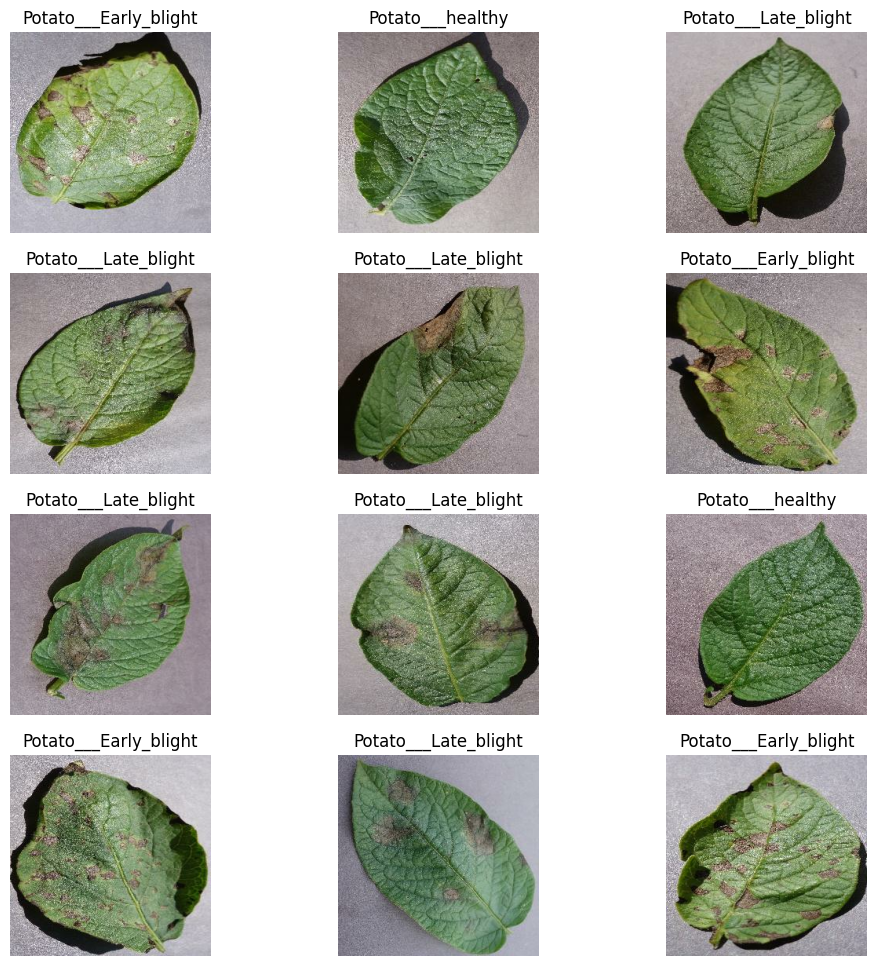

In [16]:
plt.figure(figsize=(12, 12))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [17]:
train_size = 0.8
train = len(dataset)*train_size
train

54.400000000000006

In [18]:
train_ds = dataset.take(int(train))
len(train_ds)

54

In [19]:
test_ds = dataset.skip(int(train))
len(test_ds)

14

In [20]:
val_size = 0.1
val = len(dataset)*val_size

In [21]:
val_ds = test_ds.take(int(val))
len(val_ds)

6

In [22]:
test_ds = test_ds.skip(int(val))
len(test_ds)

8

In [23]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_size=0.1, shuffle=True, shuffle_size = 10000 ):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [24]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [25]:
len(train_ds)

54

In [26]:
len(val_ds)

6

In [27]:
len(test_ds)

8

In [28]:
# Making the training faster by simultanously using the GPU and CPU
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [29]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [30]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [31]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(n_classes, activation='softmax')
    
])
model.build(input_shape=input_shape)

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [33]:
model.compile(
optimizer="adam",
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [34]:
history = model.fit(
train_ds,
epochs=EPOCHS,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds
)

Epoch 1/5
54/54 [==============================] - 685s 8s/step - loss: 0.7205 - accuracy: 0.6661 - val_loss: 0.6297 - val_accuracy: 0.8177
Epoch 2/5
54/54 [==============================] - 289s 5s/step - loss: 0.3478 - accuracy: 0.8709 - val_loss: 0.4335 - val_accuracy: 0.8646
Epoch 3/5
54/54 [==============================] - 427s 8s/step - loss: 0.2570 - accuracy: 0.9016 - val_loss: 0.2954 - val_accuracy: 0.8802
Epoch 4/5
54/54 [==============================] - 393s 7s/step - loss: 0.1956 - accuracy: 0.9294 - val_loss: 0.2242 - val_accuracy: 0.9271
Epoch 5/5
54/54 [==============================] - 460s 9s/step - loss: 0.1948 - accuracy: 0.9282 - val_loss: 0.1958 - val_accuracy: 0.9062


In [35]:
history.history

{'loss': [0.7204535603523254,
  0.34781309962272644,
  0.2569706439971924,
  0.19563476741313934,
  0.19475232064723969],
 'accuracy': [0.6660879850387573,
  0.8709490895271301,
  0.9016203880310059,
  0.9293981194496155,
  0.9282407164573669],
 'val_loss': [0.6297315955162048,
  0.4334785044193268,
  0.2954120337963104,
  0.22423295676708221,
  0.19577361643314362],
 'val_accuracy': [0.8177083134651184,
  0.8645833134651184,
  0.8802083134651184,
  0.9270833134651184,
  0.90625]}

In [36]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 152s 1s/step - loss: 0.1722 - accuracy: 0.9336


In [37]:
scores

[0.17216721177101135, 0.93359375]

In [38]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

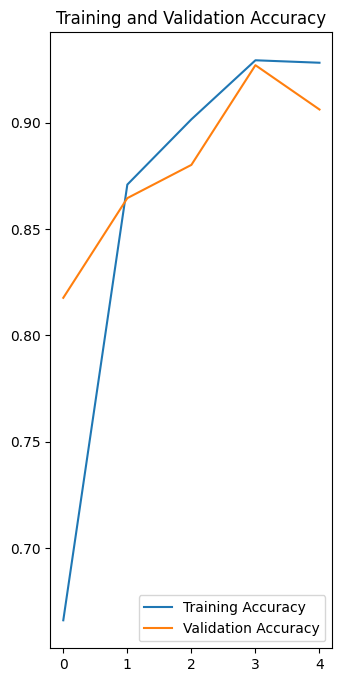

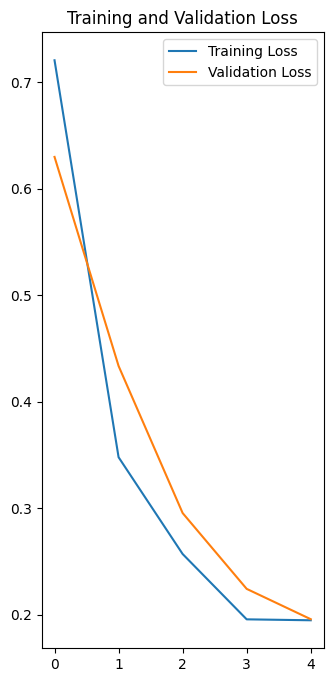

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image actual label: Potato___healthy
1/1 [==============================] - 18s 18s/step
predicted label: Potato___healthy


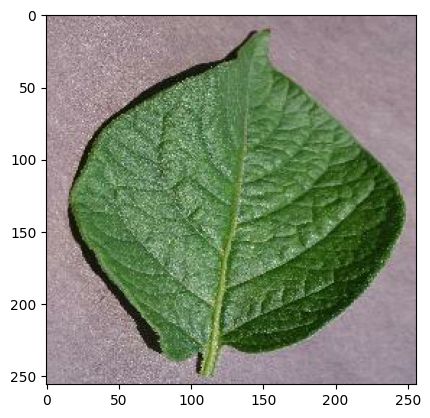

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('first image actual label:', class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print('predicted label:', class_names[np.argmax(batch_prediction[0])])
    

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 229ms/step


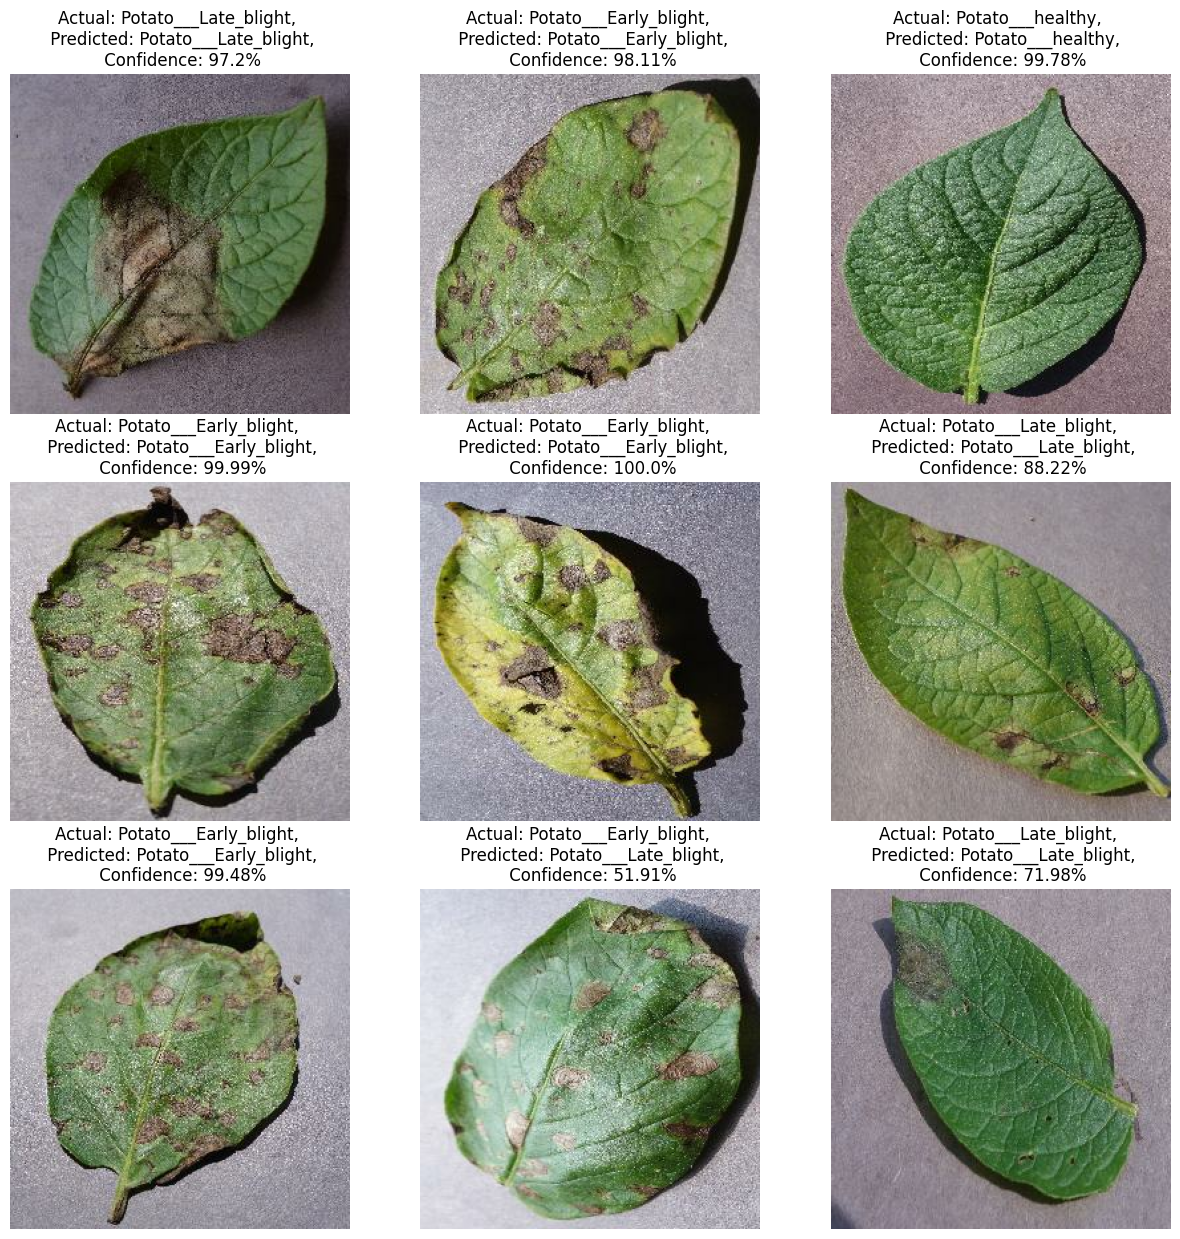

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class},\n Confidence: {confidence}%")
        plt.axis('off')

In [45]:
print(tf.__version__)

2.13.0


In [47]:
import os
model_version = max([int(i) for i in os.listdir("../Models") + [0]])+1
model_path = f"../Models/{model_version}"

model.save(model_path)




INFO:tensorflow:Assets written to: ../Models/5\assets


INFO:tensorflow:Assets written to: ../Models/5\assets
